In [48]:
!pip install pandas-profiling
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas_profiling

In [60]:
# Upload Mobility report dataset for 2021
df = pd.read_csv('datasets/2021_GB_Region_Mobility_Report.csv')

# Upload Mobility report dataset for 2021
df0 = pd.read_csv('datasets/2020_GB_Region_Mobility_Report.csv')

# Concat datasets
df = pd.concat([df0, df])
df.drop(['country_region_code', 'country_region'], axis=1)

# Upload restrictions dataset
df1 = pd.read_csv('datasets/restrictions_daily.csv')

# Merge datatsets
data = pd.merge(df, df1, how="inner", on=["date"])

# Obtain report of the dataset
prof = pandas_profiling.ProfileReport(data)
prof.to_file(output_file='output.html')

data.to_csv('datasets/london_mobility_restrictions.csv')

In [14]:
from matplotlib.dates import DateFormatter

df2 = pd.read_excel('tfl-journeys-type.xlsx', sheet_name=1)

df2

'''Problem: this dataset has the MONTHLY JOURNEYS'''

# df = df.loc[df['Period beginning'] > '2020-01-01']
# plt.figure(figsize=(20, 10))
# # plt.plot(df['Period beginning'], df['Bus journeys (m)'], '.-r', label='Bus')
# # plt.plot(df['Period beginning'], df['Underground journeys (m)'], '.-y', label='Underground')
# # plt.plot(df['Period beginning'], df['DLR Journeys (m)'], '.-g', label='DLR')
# # plt.plot(df['Period beginning'], df['Tram Journeys (m)'], '.-b', label='Tram')
# legend= ['Bus', 'Underground','DLR', 'Tram' ]
# plt.stackplot(df['Period beginning'],df['Bus journeys (m)'], df['Underground journeys (m)'],df['DLR Journeys (m)'], df['Tram Journeys (m)'] , labels=legend )
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.title('Number of journeys on the public transport network by type of transport (in millions)', fontsize=20)
# plt.show()

,Period and Financial year,Reporting Period,Days in period,Period beginning,Period ending,Bus journeys (m),Underground journeys (m),DLR Journeys (m),Tram Journeys (m),Overground Journeys (m),Emirates Airline Journeys (m),TfL Rail Journeys (m)
0,01_10/11,1,31,2010-04-01,2010-05-01,189.114661,90.545391,6.291000,2.287785,NaN,NaN,NaN
1,02_10/11,2,28,2010-05-02,2010-05-29,181.604792,84.517504,5.813000,2.154791,NaN,NaN,NaN
2,03_10/11,3,28,2010-05-30,2010-06-26,175.883173,84.286014,5.752000,2.129122,NaN,NaN,NaN
3,04_10/11,4,28,2010-06-27,2010-07-24,183.428052,86.479612,6.064480,2.141941,NaN,NaN,NaN
4,05_10/11,5,28,2010-07-25,2010-08-21,160.422767,82.895287,5.767624,2.008482,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
138,09_19/20,9,28,2020-11-15,2020-12-12,88.994047,32.123281,4.008240,1.130222,6.704696,0.020520,2.076430
139,10_19/20,10,28,2020-12-13,2021-01-09,57.480443,18.829917,2.741322,0.738954,3.571976,0.029085,1.218441
140,11_19/20,11,28,2021-01-10,2021-02-06,51.707250,16.750937,2.662126,0.668001,3.519877,0.018906,1.154206
141,12_19/20,12,28,2021-02-07,2021-03-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [154]:
from bokeh.models import LogColorMapper
from bokeh.palettes import RdYlBu11 as palette
from bokeh.palettes import Viridis6
from bokeh.plotting import figure
from bokeh.models import (
    GeoJSONDataSource,
    HoverTool,
    LinearColorMapper
)
from bokeh.io import show, output_notebook, output_file
import json



with open('datasets/london_boroughs.geojson') as f:
    london_source = GeoJSONDataSource(geojson=f.read())

with open('datasets/CycleRoutes.geojson') as f:
    cycle_source = GeoJSONDataSource(geojson=f.read())



color_mapper = LinearColorMapper(palette=Viridis6)

TOOLS = "pan,wheel_zoom,box_zoom,reset,hover,save"

p = figure(title="Cycle Routes", tools=TOOLS, x_axis_location=None,
           y_axis_location=None, width=600, height=400)
p.grid.grid_line_color = None


# Plot map of Greater London
p.patches('xs', 'ys', source=london_source,
          fill_color={'field': '@name', 'transform': color_mapper},
          fill_alpha=1.0, line_color="black", line_width=0.5)

# Plot cycle routes on top
p.multi_line('xs', 'ys', source=cycle_source, line_alpha=1, line_color='blue',
             line_width=0.7)

        


hover = p.select_one(HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = [("Borough", "@name")]

output_file("Cycle_Routes.html", title="Cycle Routes")

show(p)

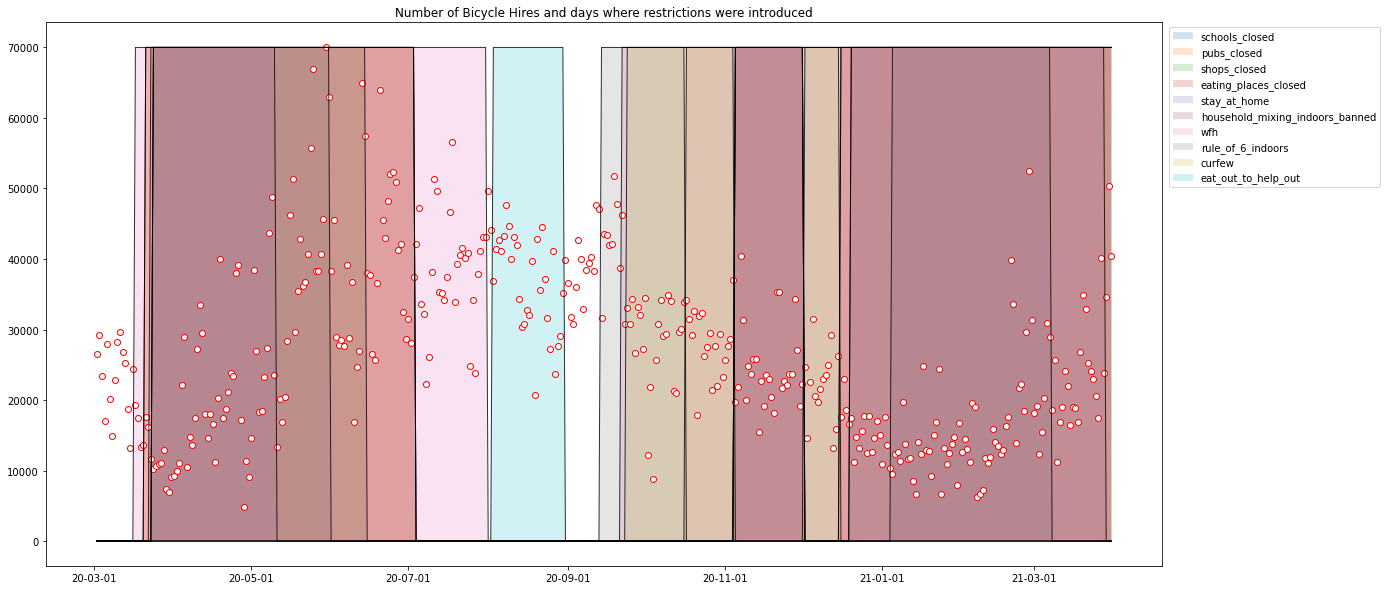

In [152]:
import pandas as pd
from matplotlib.dates import DateFormatter
cycle_hires = pd.read_excel('datasets/tfl-daily-cycle-hires.xlsx', sheet_name='Data')



# remove data previous to 2020
cycle_hires = cycle_hires.loc[cycle_hires['Day']>'2020-03-01']
df1 = df1.loc[df1['date']>'2020-03-01']
# remove data after 2021-04-01
df1 = df1.loc[df1['date']<'2021-04-01']
cycle_hires = cycle_hires.loc[cycle_hires['Day']<'2021-04-01']

fig, ax = plt.subplots(figsize=(20,10))

ax.plot(cycle_hires['Day'], cycle_hires['Number of Bicycle Hires'], 'wo',  mec='red', mew=1)




for col in df1.columns[1:]:
    ax.plot(cycle_hires['Day'], df1[col]*70000, alpha=0.8,linestyle='-', linewidth=1, color='black')
    ax.fill_between(cycle_hires['Day'], df1[col]*70000, label=col, alpha=0.2,)
    
#     for value in df1[col]:
#         if value == 1:
#             ax.plot(cycle_hires['Day'], 70000)
#          ax.fill_between(cycle_hires['Day'], df1[col], label=col, alpha=0.3)
    
ax.xaxis.set_major_formatter(DateFormatter("%y-%m-%d"))
plt.legend(bbox_to_anchor=(1.2, 1), loc='upper right')
plt.title('Number of Bicycle Hires and days where restrictions were introduced')
plt.show()

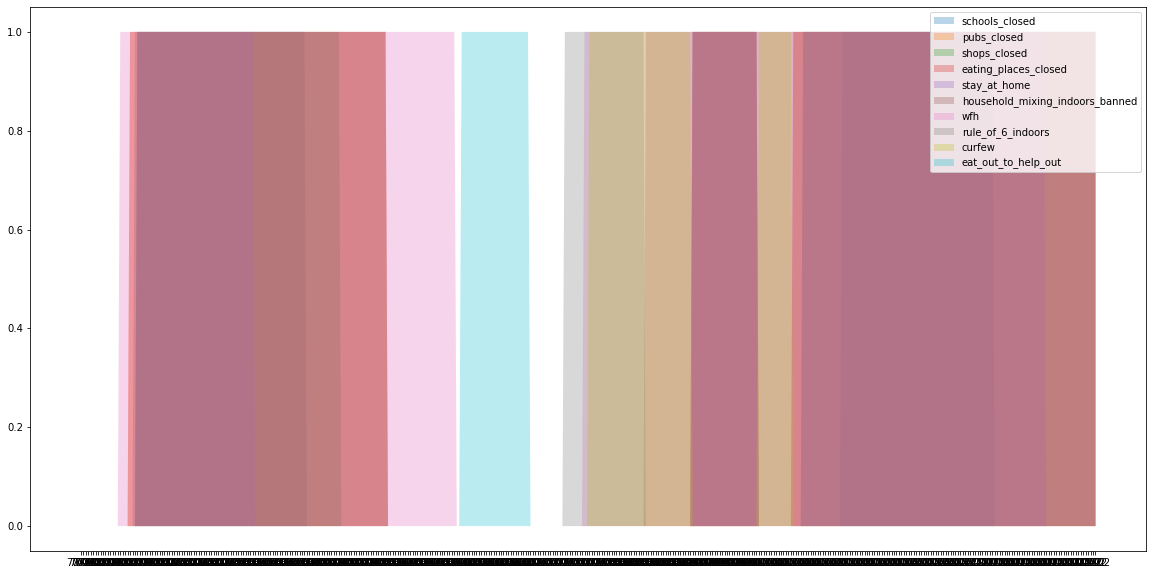